# Ref: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [248]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from subprocess import check_output
print(check_output(["ls", "/home/magic/Documents/kaggle_data/house_predict"]).decode("utf8"))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [249]:
train = pd.read_csv('/home/magic/Documents/kaggle_data/house_predict/train.csv')
test = pd.read_csv('/home/magic/Documents/kaggle_data/house_predict/test.csv')

In [149]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [150]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [250]:
# check the numbers of samples and features
print("The train data size before dropping Id feature is: {}".format(train.shape))
print("The test data size before dropping Id feature is: {}".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Drop the 'Id' column since it's unnecessary for the prediction process
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

# Check again the data size after dropping the 'Id', variable
print("\nThe train data size after dropping Id feature is: {}".format(train.shape))
print("The test data size after dropping Id feature is: {}".format(test.shape))

The train data size before dropping Id feature is: (1460, 81)
The test data size before dropping Id feature is: (1459, 80)

The train data size after dropping Id feature is: (1460, 80)
The test data size after dropping Id feature is: (1459, 79)


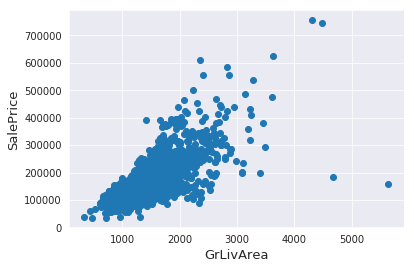

In [251]:
# Data Processing - Outliers
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [252]:
# Deleting outliers
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index, inplace=True)

Text(0.5, 0, 'GrLivArea')

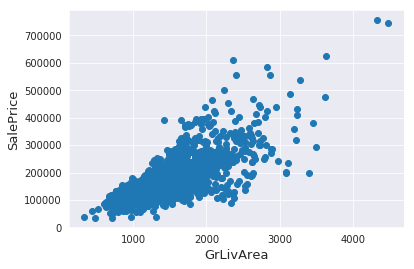

In [253]:
# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

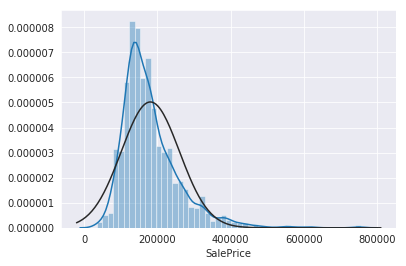

In [254]:
# Target Variable
sns.distplot(train['SalePrice'], fit=norm);

In [255]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

mu = 180932.92 and sigma = 79467.79



Text(0.5, 1.0, 'SalePrice distribution')

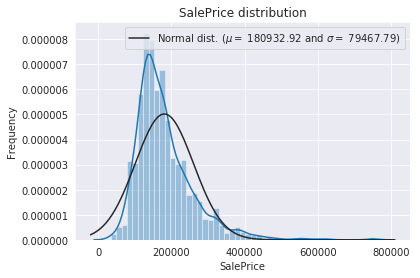

In [256]:
sns.distplot(train['SalePrice'], fit=norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='besst')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

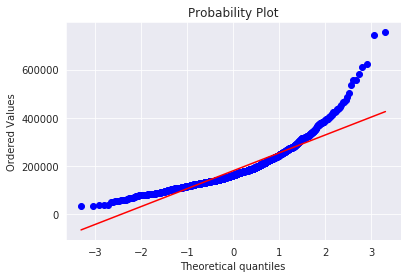

In [257]:
# Get the QQ-plot，紅色線為最小平方線
# 關於QQ-plot(分位圖）http://www.math.nsysu.edu.tw/StatDemo/QQNormaPlot/QQNormalPlot.html#five
fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [258]:
# Use the numpy function log1p which applies log(1+x) to all elements of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

 mu = 12.02 and sigma = 0.40 



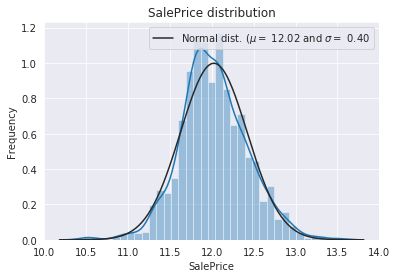

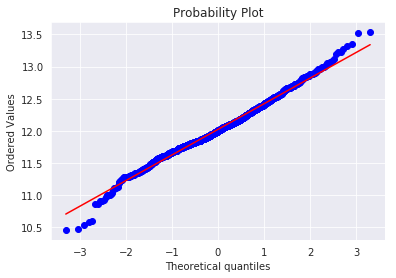

In [259]:
# Check the new distribution
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print(' mu = {:.2f} and sigma = {:.2f} \n'.format(mu, sigma))

# plot the distribution
plt.legend(['Normal dist. ($\mu =$ {:.2f} and $\sigma =$ {:.2f}'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# Features engineering

In [260]:
# get number of rows of data for later using
ntrain = train.shape[0]
ntest = test.shape[0]

In [261]:
y_train = train.SalePrice.values

In [246]:
y_train

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [262]:
all_data = pd.concat((train, test)).reset_index(drop=True)

In [263]:
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [264]:
print("all_data size is: {}".format(all_data.shape))

all_data size is: (2917, 79)


In [265]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100

In [266]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

In [267]:
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

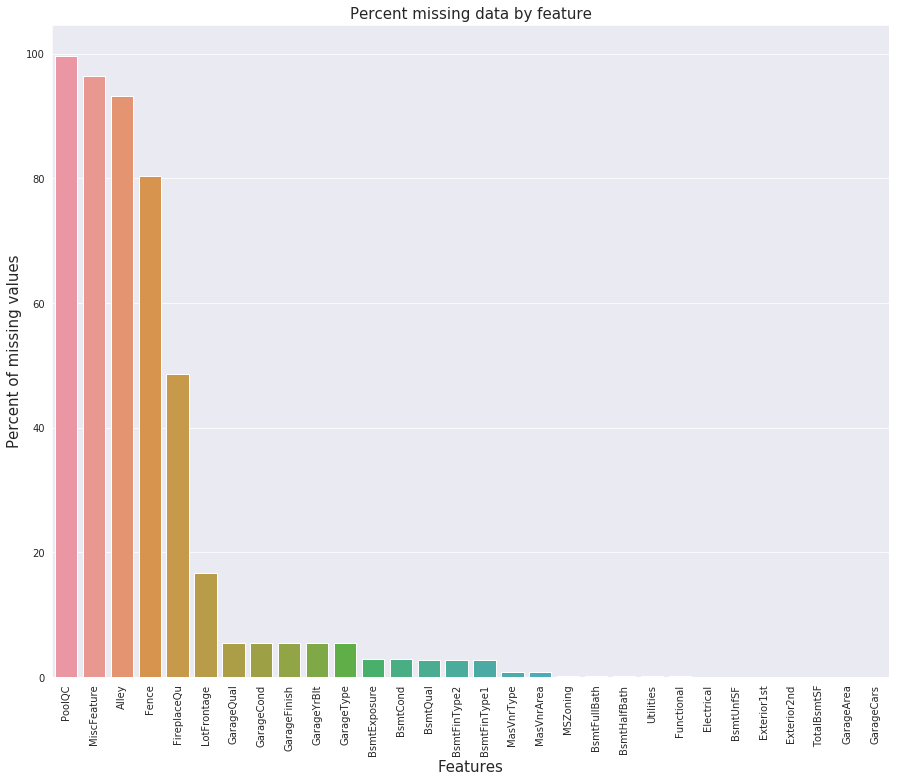

In [268]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

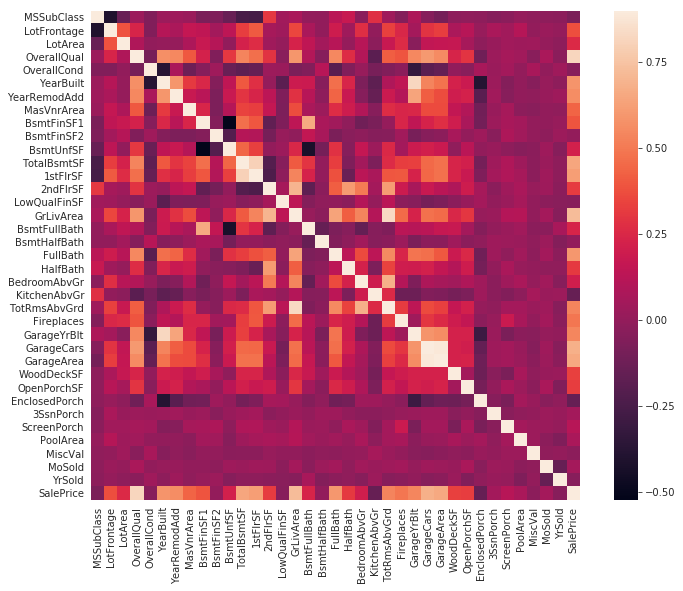

In [269]:
# Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

# Imputing missing values

In [270]:
all_data["PoolQC"] = all_data['PoolQC'].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [271]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [272]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [273]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [274]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [275]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [276]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [277]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [278]:
# All records are "AllPub", except for 1 "NoSeWa"and 2 NA
all_data = all_data.drop(['Utilities'], axis=1)

In [279]:
all_data['Functional'] = all_data['Functional'].fillna("Typ")

In [280]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [281]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [282]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [283]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [284]:
all_data['MSSubClass'].isnull().sum()

0

In [285]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()

,Missing Ratio


In [286]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

In [287]:
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

In [288]:
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

- Label Enconding some categorical variables that may contain information in their ordering set

In [289]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))
    
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


@ Adding one more feature - total area of the house

In [290]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Skewed features

In [291]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [292]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [293]:
print("\n Skew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)


 Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [294]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform


In [295]:
from scipy.special import boxcox1p

In [296]:
skewed_features = skewness.index
skewed_features

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'LandSlope', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch',
       'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF',
       'WoodDeckSF', '1stFlrSF', 'LotFrontage', 'GrLivArea', 'TotalSF',
       'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'HeatingQC',
       'FireplaceQu', 'BedroomAbvGr', 'GarageArea', 'OverallQual', 'FullBath',
       'MSSubClass', 'YrSold', 'BsmtFinType1', 'GarageCars', 'YearRemodAdd',
       'BsmtQual', 'YearBuilt', 'GarageFinish', 'LotShape', 'MoSold', 'Alley',
       'BsmtExposure', 'KitchenQual', 'ExterQual', 'Fence', 'ExterCond',
       'BsmtCond', 'PavedDrive', 'BsmtFinType2', 'GarageQual', 'CentralAir',
       'GarageCond', 'GarageYrBlt', 'Functional', 'Street', 'PoolQC'],
      dtype='object')

In [297]:
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

# Getting dummy categorical featrues

In [298]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [299]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modeling

In [300]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [301]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [306]:
model_xgb = xgb.XGBRegressor()
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[22:35:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost score: 0.1235 (0.0048)



In [309]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
xgb_pred

[22:38:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([120864.49 , 163474.19 , 188059.47 , ..., 157813.31 , 119822.055,
       234094.48 ], dtype=float32)

In [310]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv', index=False)

In [311]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
xgb_pred

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv', index=False)

Xgboost score: 0.1167 (0.0052)

